<a href="https://colab.research.google.com/github/twishi03/Llms/blob/main/Pathology_Foundation_Models_PLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generating synthetic data...
Generated 200 synthetic images.
Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:01<00:00, 35.9MB/s]


Starting training...
Epoch 1/10, Loss: 0.4623
Epoch 2/10, Loss: 0.0853
Epoch 3/10, Loss: 0.0036
Epoch 4/10, Loss: 0.0013
Epoch 5/10, Loss: 0.0005
Epoch 6/10, Loss: 0.0007
Epoch 7/10, Loss: 0.0003
Epoch 8/10, Loss: 0.0002
Epoch 9/10, Loss: 0.0004
Epoch 10/10, Loss: 0.0003
Training finished.
Starting evaluation...
Accuracy of the model on the 40 test images: 100.00%


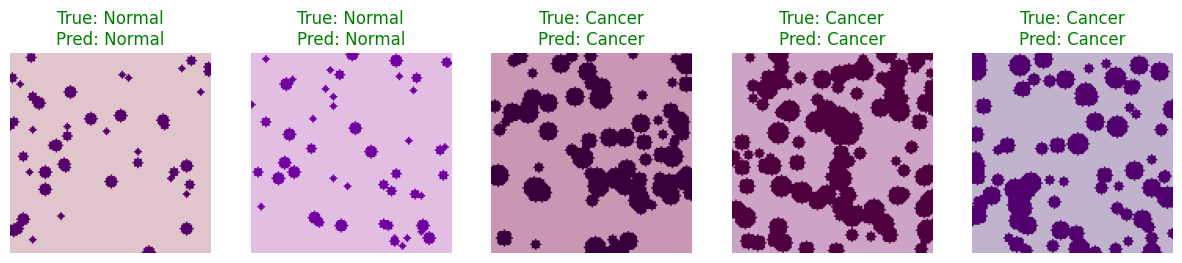

In [2]:
# write a code to classify H&E image of cancer or normal using PLIP model.
!pip install torch torchvision matplotlib numpy pandas scikit-image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet18
from skimage import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import os

# Step 1: Define the PLIP-like model (using a simple ResNet as a base)
# Since the actual PLIP architecture is complex and not readily available as a simple library,
# we'll use a standard CNN architecture (ResNet18) as a placeholder.
# A real PLIP would likely involve more sophisticated attention mechanisms and multi-modal data.

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        # Use a pre-trained ResNet18 model
        self.resnet = resnet18(pretrained=True)
        # Replace the final fully connected layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Step 2: Create Synthetic H&E Image Data
# This is a simplified approach to generate synthetic data.
# For real applications, you would use actual H&E images.

def create_synthetic_image(is_cancer, size=(128, 128)):
    img = np.zeros((*size, 3), dtype=np.uint8)
    # Simulate H&E staining: Pinkish (Eosin) and Bluish-Purple (Hematoxylin)
    # Normal tissue: More uniform distribution of colors, less dense nuclei
    # Cancer tissue: Denser, irregularly shaped nuclei, more varied staining

    if is_cancer:
        # Simulate denser, irregular nuclei
        num_nuclei = np.random.randint(50, 150)
        nucleus_color = (np.random.randint(50, 100), 0, np.random.randint(50, 150)) # Bluish-purple
        background_color = (np.random.randint(180, 220), np.random.randint(150, 190), np.random.randint(180, 220)) # Pinkish

        img[:, :] = background_color # Eosin background
        for _ in range(num_nuclei):
            center_x, center_y = np.random.randint(0, size[0]), np.random.randint(0, size[1])
            radius = np.random.randint(3, 8)
            # Simple circle drawing
            for i in range(max(0, center_x - radius), min(size[0], center_x + radius + 1)):
                for j in range(max(0, center_y - radius), min(size[1], center_y + radius + 1)):
                    if (i - center_x)**2 + (j - center_y)**2 <= radius**2:
                        img[i, j] = nucleus_color # Hematoxylin nuclei
    else:
        # Simulate normal tissue
        num_nuclei = np.random.randint(20, 70)
        nucleus_color = (np.random.randint(80, 120), 0, np.random.randint(80, 180))
        background_color = (np.random.randint(200, 240), np.random.randint(170, 210), np.random.randint(200, 240))

        img[:, :] = background_color
        for _ in range(num_nuclei):
            center_x, center_y = np.random.randint(0, size[0]), np.random.randint(0, size[1])
            radius = np.random.randint(2, 5)
            for i in range(max(0, center_x - radius), min(size[0], center_x + radius + 1)):
                for j in range(max(0, center_y - radius), min(size[1], center_y + radius + 1)):
                    if (i - center_x)**2 + (j - center_y)**2 <= radius**2:
                        img[i, j] = nucleus_color

    return Image.fromarray(img)

# Generate synthetic dataset
NUM_SAMPLES = 200 # Number of synthetic images
synthetic_data = []
labels = []
image_dir = 'synthetic_he_images'
os.makedirs(image_dir, exist_ok=True)

print("Generating synthetic data...")
for i in range(NUM_SAMPLES):
    is_cancer = i % 2 == 0 # Alternate between cancer and normal
    label = 1 if is_cancer else 0 # 1 for cancer, 0 for normal
    img = create_synthetic_image(is_cancer)
    img_path = os.path.join(image_dir, f'image_{i}.png')
    img.save(img_path)
    synthetic_data.append(img_path)
    labels.append(label)

print(f"Generated {NUM_SAMPLES} synthetic images.")

# Step 3: Create a Custom Dataset Class
class HEDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB') # Ensure image is RGB
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Step 4: Define Transformations
# Transformations are needed to preprocess the images for the model.
# Common transformations include resizing, cropping, normalization, and data augmentation.

data_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize for ResNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet mean/std
])

# Step 5: Split Data and Create DataLoaders
# Split the synthetic data into training and testing sets.

X_train, X_test, y_train, y_test = train_test_split(synthetic_data, labels, test_size=0.2, random_state=42)

train_dataset = HEDataset(X_train, y_train, transform=data_transform)
test_dataset = HEDataset(X_test, y_test, transform=data_transform)

# DataLoaders handle batching and shuffling the data.
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Step 6: Initialize Model, Loss Function, and Optimizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = SimpleCNN(num_classes=2)
model.to(device)

criterion = nn.CrossEntropyLoss() # Suitable for classification tasks
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer is commonly used

# Step 7: Train the Model
print("Starting training...")
num_epochs = 10

for epoch in range(num_epochs):
    model.train() # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() # Zero the parameter gradients

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward() # Backpropagate the loss
        optimizer.step() # Update model parameters

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

print("Training finished.")

# Step 8: Evaluate the Model
print("Starting evaluation...")
model.eval() # Set the model to evaluation mode
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad(): # No need to compute gradients during evaluation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())


accuracy = 100 * correct / total
print(f'Accuracy of the model on the {total} test images: {accuracy:.2f}%')

# Step 9: Visualize Results (Example)
# You can visualize some predictions and their corresponding images.

def visualize_predictions(image_paths, true_labels, predicted_labels, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(min(num_images, len(image_paths))):
        img = Image.open(image_paths[i]).convert('RGB')
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        true_class = "Cancer" if true_labels[i] == 1 else "Normal"
        predicted_class = "Cancer" if predicted_labels[i] == 1 else "Normal"
        plt.title(f'True: {true_class}\nPred: {predicted_class}', color="green" if true_class == predicted_class else "red")
        plt.axis('off')
    plt.show()

# Select a few test images and their predictions
num_viz_images = 5
viz_image_paths = X_test[:num_viz_images]
viz_true_labels = y_test[:num_viz_images]
viz_predicted_labels = all_predictions[:num_viz_images]

visualize_predictions(viz_image_paths, viz_true_labels, viz_predicted_labels, num_images=num_viz_images)

# Clean up synthetic images directory
# !rm -rf synthetic_he_images